In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [ ]:
DATA_PATH = os.path.join('..\data', 'MachineLearningRating_v3.txt')


def load_data(filepath, delimiter='|'):
    """
    Loads the insurance claims data from a text file.
    Handles potential initial loading errors and allows specifying a delimiter.

    Args:
        filepath (str): The path to the data file (.txt).
        delimiter (str): The character used to separate values in the file (e.g., ',', '\t', ';').
                         Defaults to pipe.
    """
    try:
        # pd.read_csv can read .txt files if the delimiter is correctly specified
        df = pd.read_csv(
            filepath,
            delimiter=delimiter,
            low_memory=False  # Add this option
        )
        print(f"Data loaded successfully from {filepath} with delimiter '{delimiter}'. Shape: {df.shape}")
        return df
    except FileNotFoundError:
        print(f"Error: File not found at {filepath}. Please ensure the data TXT is in the 'data' directory and named 'insurance_claims.txt'.")
        return None
    except Exception as e:
        print(f"An error occurred while loading data: {e}\n"
              "Please check if the delimiter is correct and the file format is consistent.")
        return None
    
df=load_data(DATA_PATH)

Data loaded successfully from ../data\MachineLearningRating_v3.txt with delimiter '|'. Shape: (1000098, 52)


In [ ]:
def summarize_data(df):
    """
    Provides descriptive statistics and reviews data structure.
    """
    print("\n--- Data Head ---")
    print(df.head())

    print("\n--- Data Info ---")
    df.info()

    print("\n--- Descriptive Statistics for Numerical Features ---")
    print(df.describe().T)

    print("\n--- Unique Values for Categorical Columns (Top 10) ---")
    for col in df.select_dtypes(include='object').columns:
        print(f"\n{col}: {df[col].nunique()} unique values")
        if df[col].nunique() < 20: # Display all if few, else top 10
            print(df[col].value_counts())
        else:
            print(df[col].value_counts().head(10))

# --- Data Quality Assessment ---
def check_missing_values(df):
    """
    Checks and reports missing values.
    """
    print("\n--- Missing Values ---")
    missing_data = df.isnull().sum()
    missing_percentage = (df.isnull().sum() / len(df)) * 100
    missing_df = pd.DataFrame({'Missing Count': missing_data, 'Missing %': missing_percentage})
    print(missing_df[missing_df['Missing Count'] > 0].sort_values(by='Missing %', ascending=False))

summarize_data(df)
check_missing_values(df)


--- Data Head ---
   UnderwrittenCoverID  PolicyID     TransactionMonth  IsVATRegistered  \
0               145249     12827  2015-03-01 00:00:00             True   
1               145249     12827  2015-05-01 00:00:00             True   
2               145249     12827  2015-07-01 00:00:00             True   
3               145255     12827  2015-05-01 00:00:00             True   
4               145255     12827  2015-07-01 00:00:00             True   

  Citizenship          LegalType Title Language                 Bank  \
0              Close Corporation    Mr  English  First National Bank   
1              Close Corporation    Mr  English  First National Bank   
2              Close Corporation    Mr  English  First National Bank   
3              Close Corporation    Mr  English  First National Bank   
4              Close Corporation    Mr  English  First National Bank   

       AccountType  ...                    ExcessSelected CoverCategory  \
0  Current account  ...     

In [9]:
def preprocess_data_for_eda(df):
    """
    Performs initial preprocessing steps for EDA, including type conversions
    and creating basic time-related features.
    """
    # Convert 'TransactionDate' to datetime objects
    if 'TransactionMonth' in df.columns:
        df['TransactionDate'] = pd.to_datetime(df['TransactionMonth'], errors='coerce')
        # Extract Year and Month for temporal analysis
        df['TransactionYearMonth'] = df['TransactionDate'].dt.to_period('M')
        # Convert TransactionMonth to a datetime object for easier plotting if needed
        # Assuming 'TransactionMonth' is like '1402' for Feb 2014, '1508' for Aug 2015
        df['TransactionMonth_dt'] = df['TransactionMonth'].astype(str).apply(
            lambda x: pd.to_datetime(f'20{x[:2]}-{x[2:]}-01', errors='coerce') if len(x) == 4 else np.nan
        )
        print("Converted 'TransactionDate' and 'TransactionMonth' to datetime objects.")
    else:
        print("'TransactionDate' column not found. Skipping datetime conversion.")

    # Ensure numerical columns are numeric, coercing errors to NaN
    numerical_cols = ['TotalPremium', 'TotalClaims', 'CustomValueEstimate', 'Cylinders',
                      'Cubiccapacity', 'Kilowatts', 'NumberOfDoors', 'CapitalOutstanding',
                      'NumberOfVehiclesInFleet', 'SumInsured', 'CalculatedPremiumPerTerm',
                      'ExcessSelected', 'RegistrationYear'] # Added RegistrationYear as it's numerical
    for col in numerical_cols:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')
            # Fill NaNs for numerical columns if a simple fill is appropriate for EDA
            # df[col].fillna(df[col].median(), inplace=True) # Example: fill with median

    # Convert object columns that should be categorical to 'category' dtype
    categorical_cols = ['IsVATRegistered', 'Citizenship', 'LegalType', 'Title', 'Language',
                        'Bank', 'AccountType', 'MaritalStatus', 'Gender', 'Country', 'Province',
                        'ItemType', 'VehicleType', 'Make', 'Model', 'Bodytype', 'AlarmImmobiliser',
                        'TrackingDevice', 'NewVehicle', 'WrittenOff', 'Rebuilt', 'Converted',
                        'CrossBorder', 'CoverCategory', 'CoverType', 'CoverGroup', 'Section',
                        'Product', 'StatutoryClass', 'StatutoryRiskType']
    for col in categorical_cols:
        if col in df.columns:
            df[col] = df[col].astype('category')

    # Create Loss Ratio (handle division by zero)
    # Ensure TotalPremium is not NaN before division
    df['LossRatio'] = df.apply(
        lambda row: row['TotalClaims'] / row['TotalPremium'] if pd.notnull(row['TotalPremium']) and row['TotalPremium'] > 0 else 0,
        axis=1
    )
    print("Calculated 'LossRatio'.", df['LossRatio'].describe())

    # Create 'HadClaim' binary variable
    df['HadClaim'] = (df['TotalClaims'] > 0).astype(int)
    print("Created 'HadClaim' binary variable.")

    # Convert PostalCode to string for consistency if it's numeric
    if 'PostalCode' in df.columns:
        df['PostalCode'] = df['PostalCode'].astype(str)

    return df

prep_df=preprocess_data_for_eda(df)

Converted 'TransactionDate' and 'TransactionMonth' to datetime objects.
Calculated 'LossRatio'. count    1.000098e+06
mean     2.163699e-01
std      7.304735e+00
min     -1.870012e+01
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      2.553600e+03
Name: LossRatio, dtype: float64
Created 'HadClaim' binary variable.



--- Plotting Distributions ---


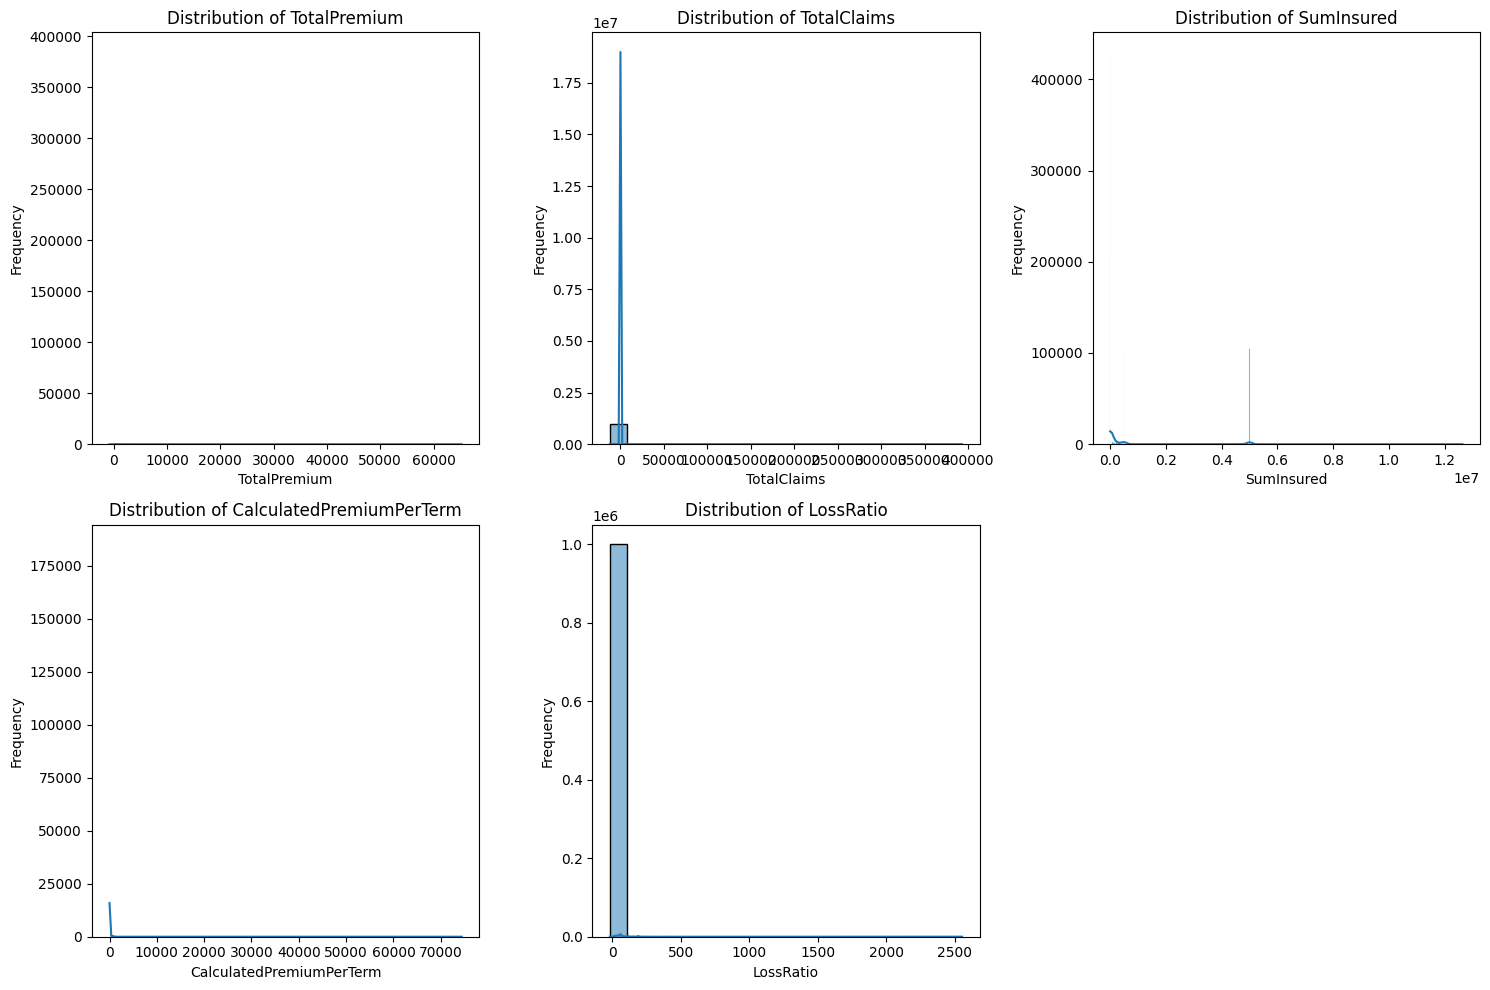

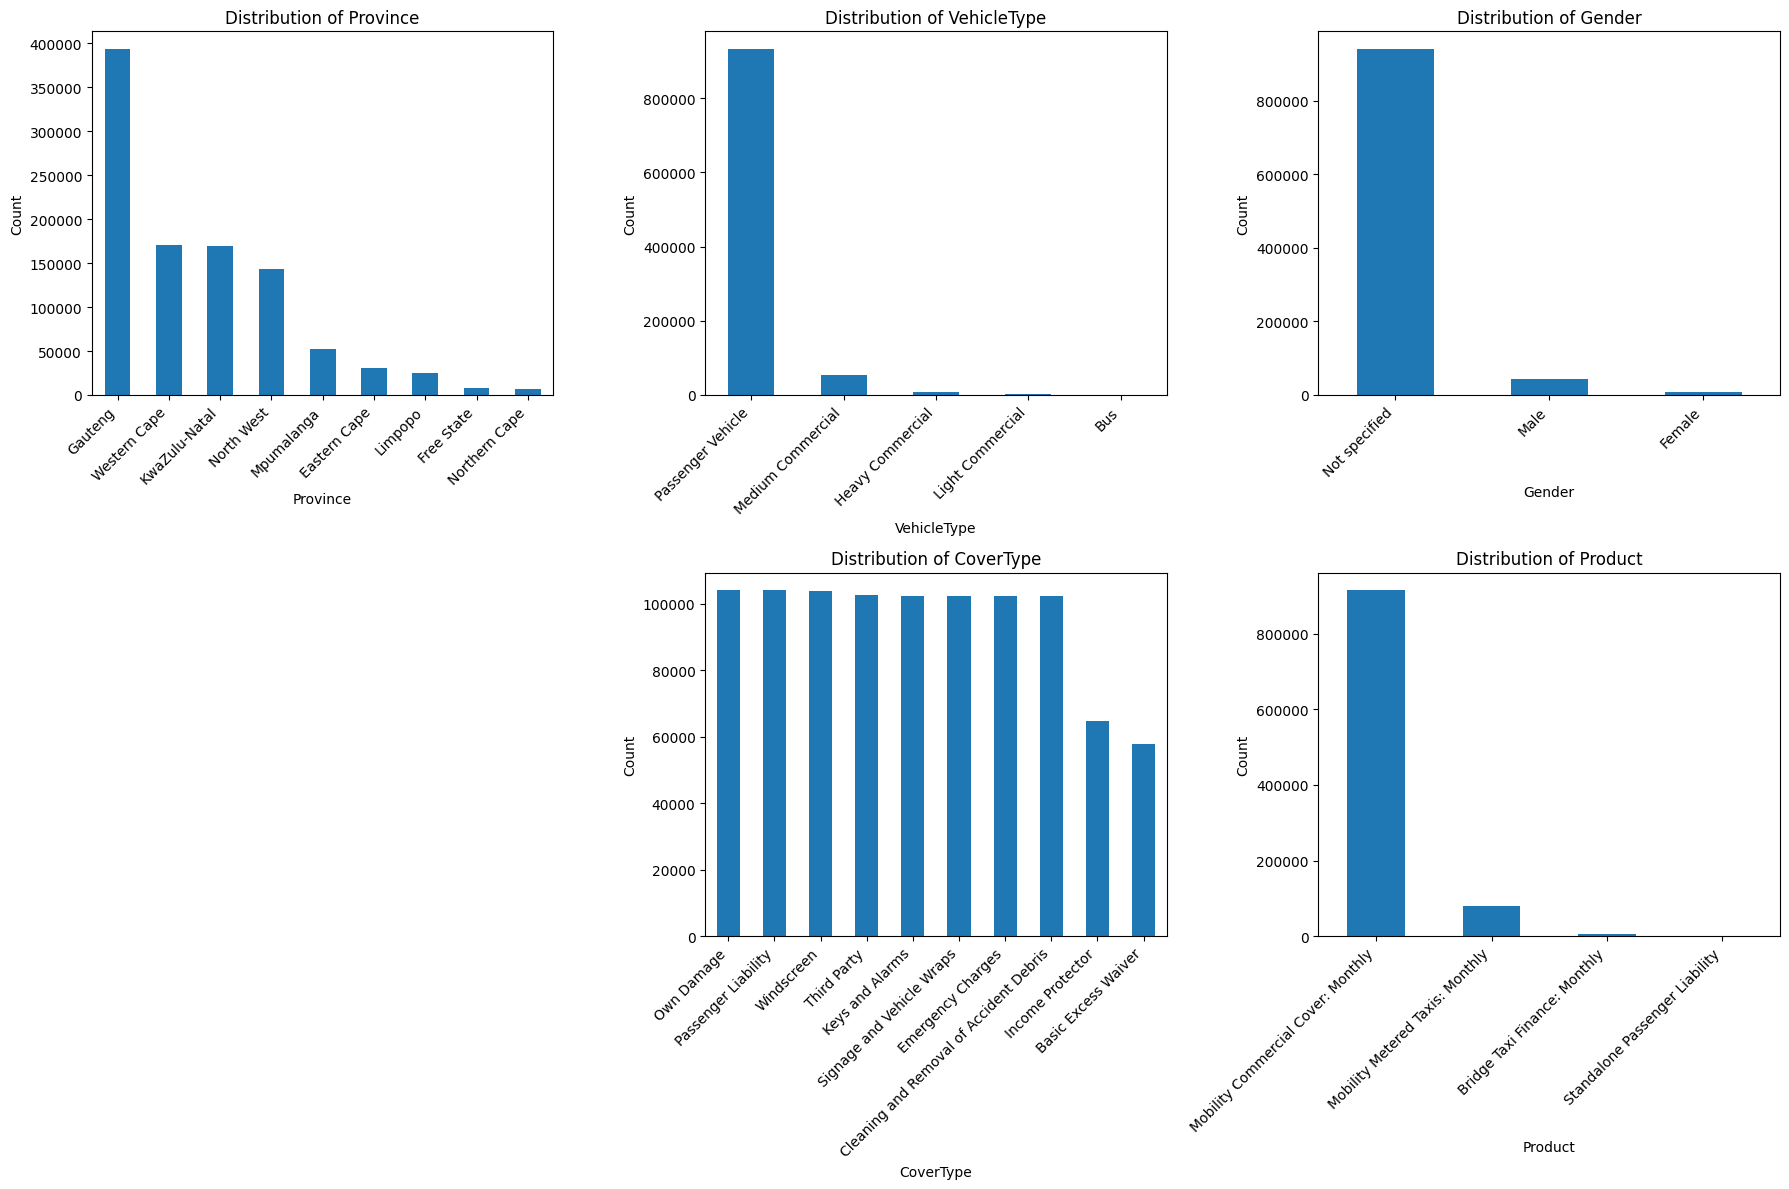

In [10]:
def plot_distributions(df):
    """
    Plots histograms for numerical columns and bar charts for categorical columns.
    """
    print("\n--- Plotting Distributions ---")

    # Numerical distributions
    numerical_cols = ['TotalPremium', 'TotalClaims', 'SumInsured', 'CalculatedPremiumPerTerm', 'LossRatio']
    plt.figure(figsize=(15, 10))
    for i, col in enumerate(numerical_cols):
        if col in df.columns:
            plt.subplot(2, 3, i + 1)
            sns.histplot(df[col].dropna(), kde=True)
            plt.title(f'Distribution of {col}')
            plt.xlabel(col)
            plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()

    # Categorical distributions (top 10 categories)
    categorical_cols_to_plot = ['Province', 'VehicleType', 'Gender', 'Make', 'CoverType', 'Product']
    plt.figure(figsize=(18, 12))
    for i, col in enumerate(categorical_cols_to_plot):
        if col in df.columns:
            plt.subplot(2, 3, i + 1)
            df[col].value_counts().nlargest(10).plot(kind='bar')
            plt.title(f'Distribution of {col}')
            plt.xlabel(col)
            plt.ylabel('Count')
            plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

plot_distributions(prep_df)


--- Exploring Relationships ---
Overall Portfolio Loss Ratio: 1.05

Loss Ratio by Province:
               TotalPremium   TotalClaims  LossRatio
Province                                            
Eastern Cape   2.140104e+06  1.356427e+06   0.633813
Free State     5.213632e+05  3.549223e+05   0.680758
Gauteng        2.405377e+07  2.939415e+07   1.222018
KwaZulu-Natal  1.320908e+07  1.430138e+07   1.082693
Limpopo        1.537324e+06  1.016477e+06   0.661199
Mpumalanga     2.836292e+06  2.044675e+06   0.720897
North West     7.490508e+06  5.920250e+06   0.790367
Northern Cape  3.165581e+05  8.949051e+04   0.282699
Western Cape   9.806559e+06  1.038977e+07   1.059472


C:\Users\Perserverence\AppData\Local\Temp\ipykernel_3652\1946958809.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  loss_ratio_by_province = df.groupby('Province').agg(
C:\Users\Perserverence\AppData\Local\Temp\ipykernel_3652\1946958809.py:30: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  loss_ratio_by_vehicle_type = df.groupby('VehicleType').agg(



Loss Ratio by Vehicle Type:
                   TotalPremium   TotalClaims  LossRatio
VehicleType                                             
Bus                5.824474e+04  7.996535e+03   0.137292
Heavy Commercial   4.609479e+05  7.504746e+05   1.628112
Light Commercial   2.604975e+05  6.045250e+04   0.232066
Medium Commercial  3.922746e+06  4.119867e+06   1.050251
Passenger Vehicle  5.664202e+07  5.937207e+07   1.048198

Loss Ratio by Gender:
               TotalPremium   TotalClaims  LossRatio
Gender                                              
Female         3.044806e+05  2.502461e+05   0.821879
Male           1.580143e+06  1.396704e+06   0.883910
Not specified  5.920275e+07  6.271410e+07   1.059311


C:\Users\Perserverence\AppData\Local\Temp\ipykernel_3652\1946958809.py:43: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  loss_ratio_by_gender = df.groupby('Gender').agg(


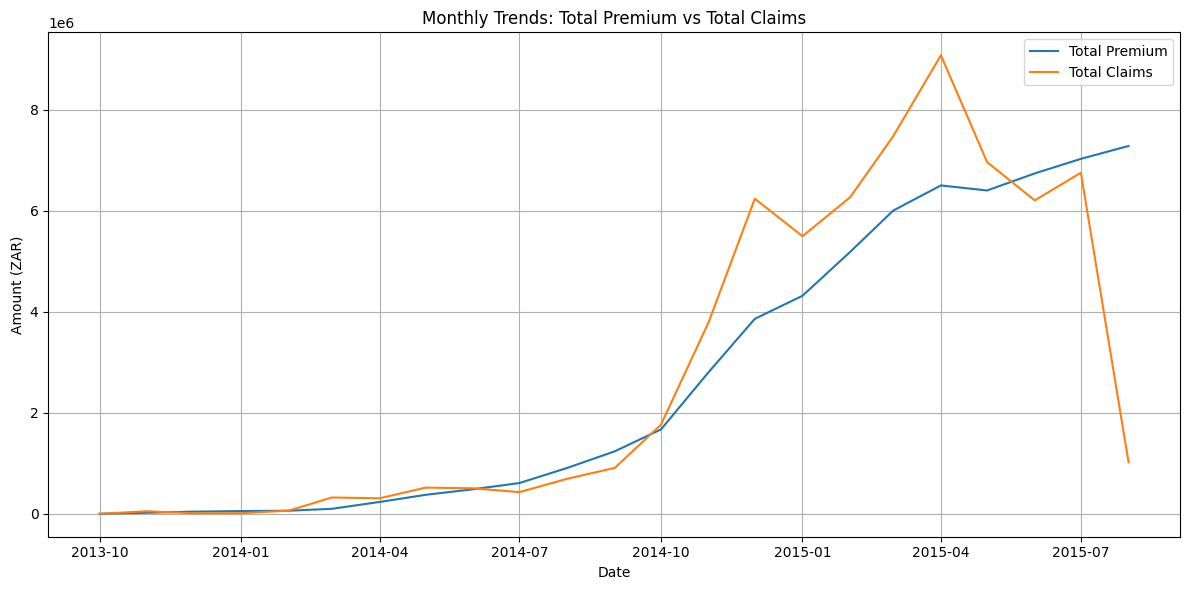


--- Correlation Matrix ---


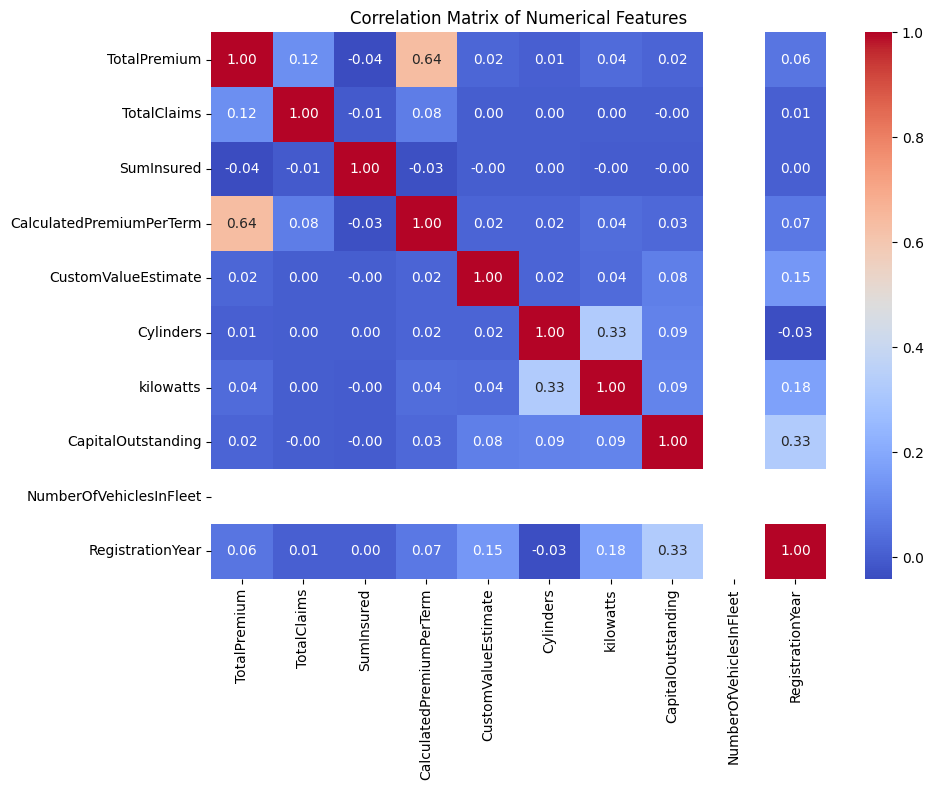

In [12]:
# --- Bivariate/Multivariate Analysis ---
def explore_relationships(df):
    """
    Explores relationships between key variables.
    """
    print("\n--- Exploring Relationships ---")

    # Overall Loss Ratio
    # Ensure sum of TotalPremium is not zero to avoid division by zero
    total_premium_sum = df['TotalPremium'].sum()
    overall_loss_ratio = df['TotalClaims'].sum() / total_premium_sum if total_premium_sum > 0 else 0
    print(f"Overall Portfolio Loss Ratio: {overall_loss_ratio:.2f}")

    # Loss Ratio by Province
    if 'Province' in df.columns:
        loss_ratio_by_province = df.groupby('Province').agg(
            TotalPremium=('TotalPremium', 'sum'),
            TotalClaims=('TotalClaims', 'sum')
        )
        # Handle potential division by zero for each group
        loss_ratio_by_province['LossRatio'] = loss_ratio_by_province.apply(
            lambda row: row['TotalClaims'] / row['TotalPremium'] if row['TotalPremium'] > 0 else 0,
            axis=1
        ).sort_values(ascending=False)
        print("\nLoss Ratio by Province:")
        print(loss_ratio_by_province)

    # Loss Ratio by VehicleType
    if 'VehicleType' in df.columns:
        loss_ratio_by_vehicle_type = df.groupby('VehicleType').agg(
            TotalPremium=('TotalPremium', 'sum'),
            TotalClaims=('TotalClaims', 'sum')
        )
        loss_ratio_by_vehicle_type['LossRatio'] = loss_ratio_by_vehicle_type.apply(
            lambda row: row['TotalClaims'] / row['TotalPremium'] if row['TotalPremium'] > 0 else 0,
            axis=1
        ).sort_values(ascending=False)
        print("\nLoss Ratio by Vehicle Type:")
        print(loss_ratio_by_vehicle_type.head(10)) # Display top 10

    # Loss Ratio by Gender
    if 'Gender' in df.columns:
        loss_ratio_by_gender = df.groupby('Gender').agg(
            TotalPremium=('TotalPremium', 'sum'),
            TotalClaims=('TotalClaims', 'sum')
        )
        loss_ratio_by_gender['LossRatio'] = loss_ratio_by_gender.apply(
            lambda row: row['TotalClaims'] / row['TotalPremium'] if row['TotalPremium'] > 0 else 0,
            axis=1
        ).sort_values(ascending=False)
        print("\nLoss Ratio by Gender:")
        print(loss_ratio_by_gender)

    # Temporal Trends of Claims and Premium
    if 'TransactionYearMonth' in df.columns:
        monthly_summary = df.groupby('TransactionYearMonth').agg(
            TotalPremium=('TotalPremium', 'sum'),
            TotalClaims=('TotalClaims', 'sum'),
            PolicyCount=('PolicyID', 'nunique')
        ).reset_index()
        # Convert to timestamp for plotting from Period
        monthly_summary['TransactionYearMonth'] = monthly_summary['TransactionYearMonth'].dt.to_timestamp()

        plt.figure(figsize=(12, 6))
        sns.lineplot(data=monthly_summary, x='TransactionYearMonth', y='TotalPremium', label='Total Premium')
        sns.lineplot(data=monthly_summary, x='TransactionYearMonth', y='TotalClaims', label='Total Claims')
        plt.title('Monthly Trends: Total Premium vs Total Claims')
        plt.xlabel('Date')
        plt.ylabel('Amount (ZAR)')
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()

    # Correlation Matrix for Numerical Features
    numerical_features_for_corr = ['TotalPremium', 'TotalClaims', 'SumInsured',
                                   'CalculatedPremiumPerTerm', 'CustomValueEstimate',
                                   'Cylinders', 'kilowatts', 'CapitalOutstanding',
                                   'NumberOfVehiclesInFleet', 'RegistrationYear'] # Added RegistrationYear
    corr_matrix = df[numerical_features_for_corr].corr()
    print("\n--- Correlation Matrix ---")
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title('Correlation Matrix of Numerical Features')
    plt.tight_layout()
    plt.show()
explore_relationships(prep_df)
# --- Save Preprocessed Data ---


--- Outlier Detection with Box Plots ---


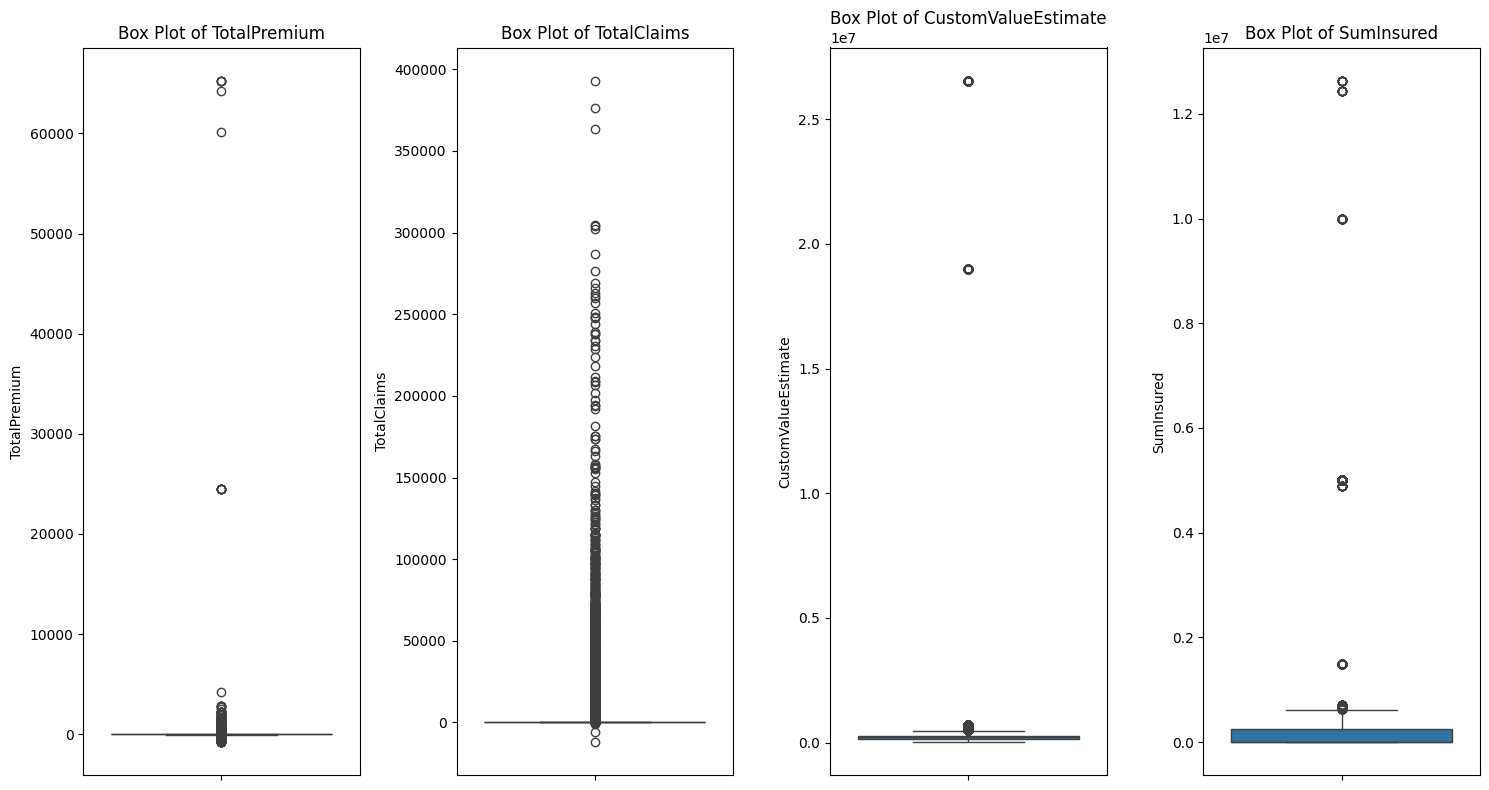


--- Generating Creative Plots ---


C:\Users\Perserverence\AppData\Local\Temp\ipykernel_3652\3501556998.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=cresta_loss_ratio.values, y=cresta_loss_ratio.index, palette='viridis')


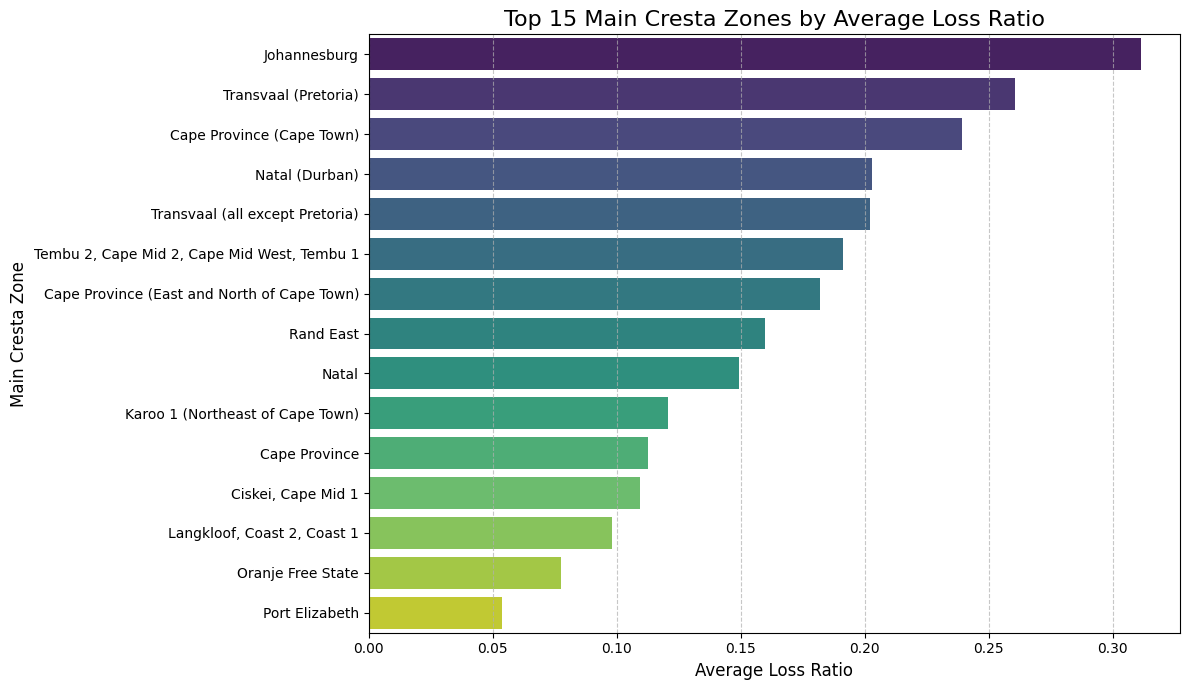

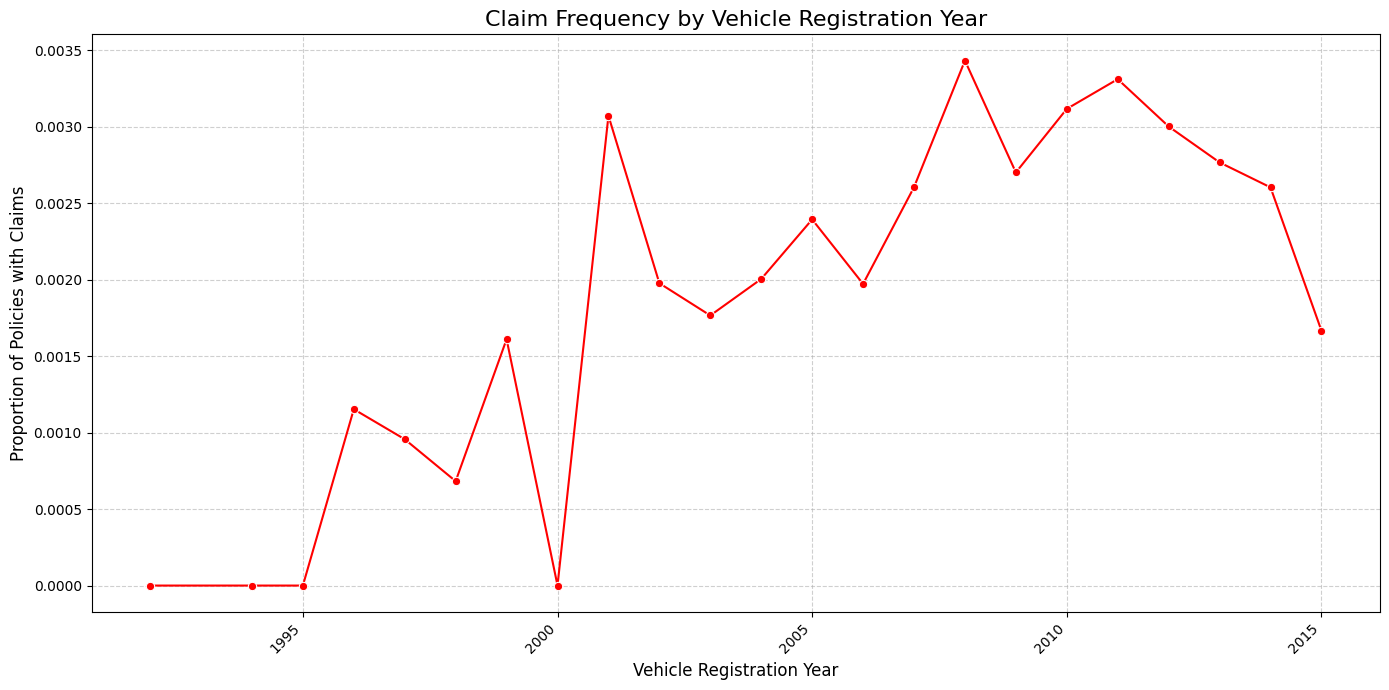

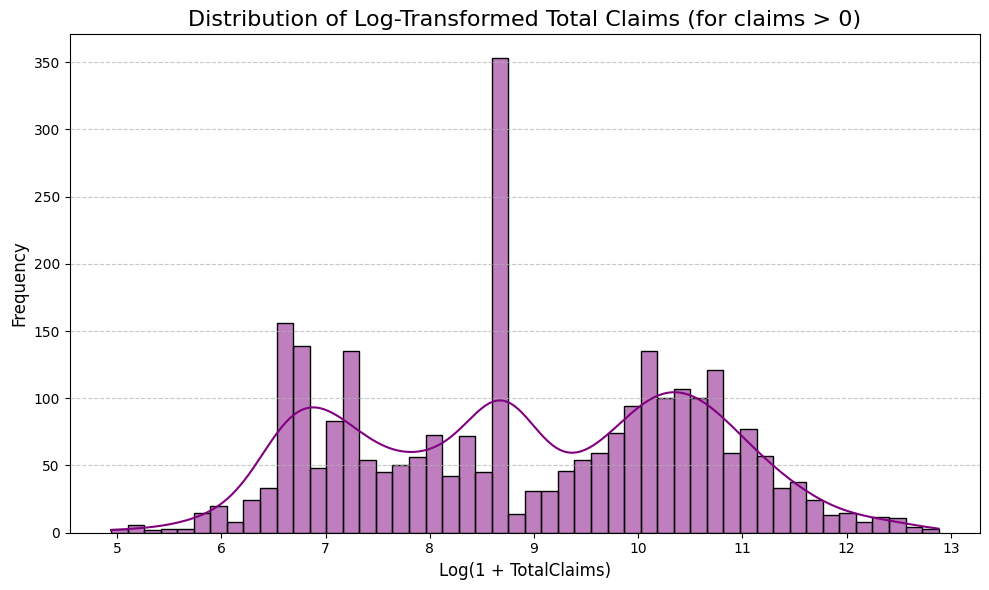

In [14]:
def detect_outliers(df):
    """
    Uses box plots to detect outliers in key numerical features.
    """
    print("\n--- Outlier Detection with Box Plots ---")
    numerical_cols_for_outliers = ['TotalPremium', 'TotalClaims', 'CustomValueEstimate', 'SumInsured']
    plt.figure(figsize=(15, 8))
    for i, col in enumerate(numerical_cols_for_outliers):
        if col in df.columns:
            plt.subplot(1, 4, i + 1)
            sns.boxplot(y=df[col].dropna())
            plt.title(f'Box Plot of {col}')
            plt.ylabel(col)
    plt.tight_layout()
    plt.show()

# --- Creative and Beautiful Plots (Examples) ---
def generate_creative_plots(df):
    """
    Produces 3 creative and insightful plots.
    """
    print("\n--- Generating Creative Plots ---")

    # Plot 1: Loss Ratio by MainCrestaZone
    if 'MainCrestaZone' in df.columns and 'LossRatio' in df.columns:
        cresta_loss_ratio = df.groupby('MainCrestaZone')['LossRatio'].mean().sort_values(ascending=False).head(15)
        plt.figure(figsize=(12, 7))
        sns.barplot(x=cresta_loss_ratio.values, y=cresta_loss_ratio.index, palette='viridis')
        plt.title('Top 15 Main Cresta Zones by Average Loss Ratio', fontsize=16)
        plt.xlabel('Average Loss Ratio', fontsize=12)
        plt.ylabel('Main Cresta Zone', fontsize=12)
        plt.grid(axis='x', linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()

    # Plot 2: Claim Frequency by Registration Year of Vehicle
    # Assuming 'RegistrationYear' indicates the year the vehicle was manufactured/registered
    if 'RegistrationYear' in df.columns and 'HadClaim' in df.columns:
        claim_frequency_by_year = df.groupby('RegistrationYear')['HadClaim'].mean().reset_index()
        claim_frequency_by_year = claim_frequency_by_year[
            (claim_frequency_by_year['RegistrationYear'] >= 1990) &
            (claim_frequency_by_year['RegistrationYear'] <= df['RegistrationYear'].max())
        ] # Filter out unrealistic years

        plt.figure(figsize=(14, 7))
        sns.lineplot(data=claim_frequency_by_year, x='RegistrationYear', y='HadClaim', marker='o', color='red')
        plt.title('Claim Frequency by Vehicle Registration Year', fontsize=16)
        plt.xlabel('Vehicle Registration Year', fontsize=12)
        plt.ylabel('Proportion of Policies with Claims', fontsize=12)
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()

    # Plot 3: Distribution of Total Claims (log-transformed)
    # Log transform helps to visualize highly skewed data better
    if 'TotalClaims' in df.columns:
        # Filter for claims > 0 to avoid log(0)
        claims_positive = df[df['TotalClaims'] > 0]['TotalClaims']
        plt.figure(figsize=(10, 6))
        sns.histplot(np.log1p(claims_positive), kde=True, bins=50, color='purple') # log1p handles 0 by adding 1
        plt.title('Distribution of Log-Transformed Total Claims (for claims > 0)', fontsize=16)
        plt.xlabel('Log(1 + TotalClaims)', fontsize=12)
        plt.ylabel('Frequency', fontsize=12)
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()
        
detect_outliers(prep_df)
generate_creative_plots(prep_df)